# PyCC Sequential Learning Tutorial

*Authors: Edward Kim, Enze Chen, Nils Persson*

In this notebook, we will cover how to perform **sequential learning** (SL) using the [Citrination API](http://citrineinformatics.github.io/python-citrination-client/). [Sequential learning](https://citrine.io/platform/sequential-learning/) is the key workflow which allows machine learning algorithms and in-lab experiments to iteratively inform each other.

To replace the need for an actual laboratory, this notebook uses a simple *toy function* that allows for "measurements" on the data.

**NOTE**: If you want to run the sequential learning code in the final part of this tutorial on the public version of Citrination (https://citrination.com), then you will need an admin account to run design jobs.

## Learning objectives

By the end of this tutorial, you will know how to:

- Use PyCC end to end, from uploading an initial dataset to running SL
- Understand how to configure SL parameters to match your laboratory setup
- Asynchronously issue SL jobs to Citrination's backend

## Background knowledge

In order to get the most out of this tutorial, you should already be familiar with the following:

- Create and access datasets through the API ([tutorial](1_data_client_api_tutorial.ipynb))
- Create and access data views through the API ([tutorial](2_data_views_api_tutorial.ipynb))
- What the data views [front-end UI](https://citrination.com/data_views) looks like, particularly the Design interface

## Imports
This notebook uses some convenience functions to wrap several API endpoints. These are listed in the file [`sequential_learning_wrappers.py`](./sequential_learning_wrappers.py) and imported below. Review the docstrings and code in that file to learn more.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib notebook

# Standard packages
from os import environ

# Third-party packages
from sequential_learning_wrappers import *   # Helper functions to wrap several API endpoints together
sns.set_context("notebook")
sns.set_style("whitegrid")
plt.rcParams.update({'figure.figsize':(8, 6),
                     'lines.markersize':8,
                     'figure.facecolor':'w'})

## Setting up a client

Make sure to properly set your **environment variable** to hold your API key.

In [2]:
client = CitrinationClient(
    environ.get("CITRINATION_API_KEY"),
    "https://citrination.com"
)
client

['models', 'search', 'data', 'data_views']

In [3]:
def toy_func(inputs):
    return np.sum((np.array(inputs)**2))

toy_x = [np.random.normal(loc=0, scale=2, size=(1, 2))[0] for x in range(20)]
toy_y = [toy_func(x) for x in toy_x]

initial_best_measured_value = min(toy_y)

print(f"Best (lowest) value in initial training set: {initial_best_measured_value}")

Best (lowest) value in initial training set: 2.1098238207692894


Now we can plot the initial training set, and color it by the function value.

<IPython.core.display.Javascript object>


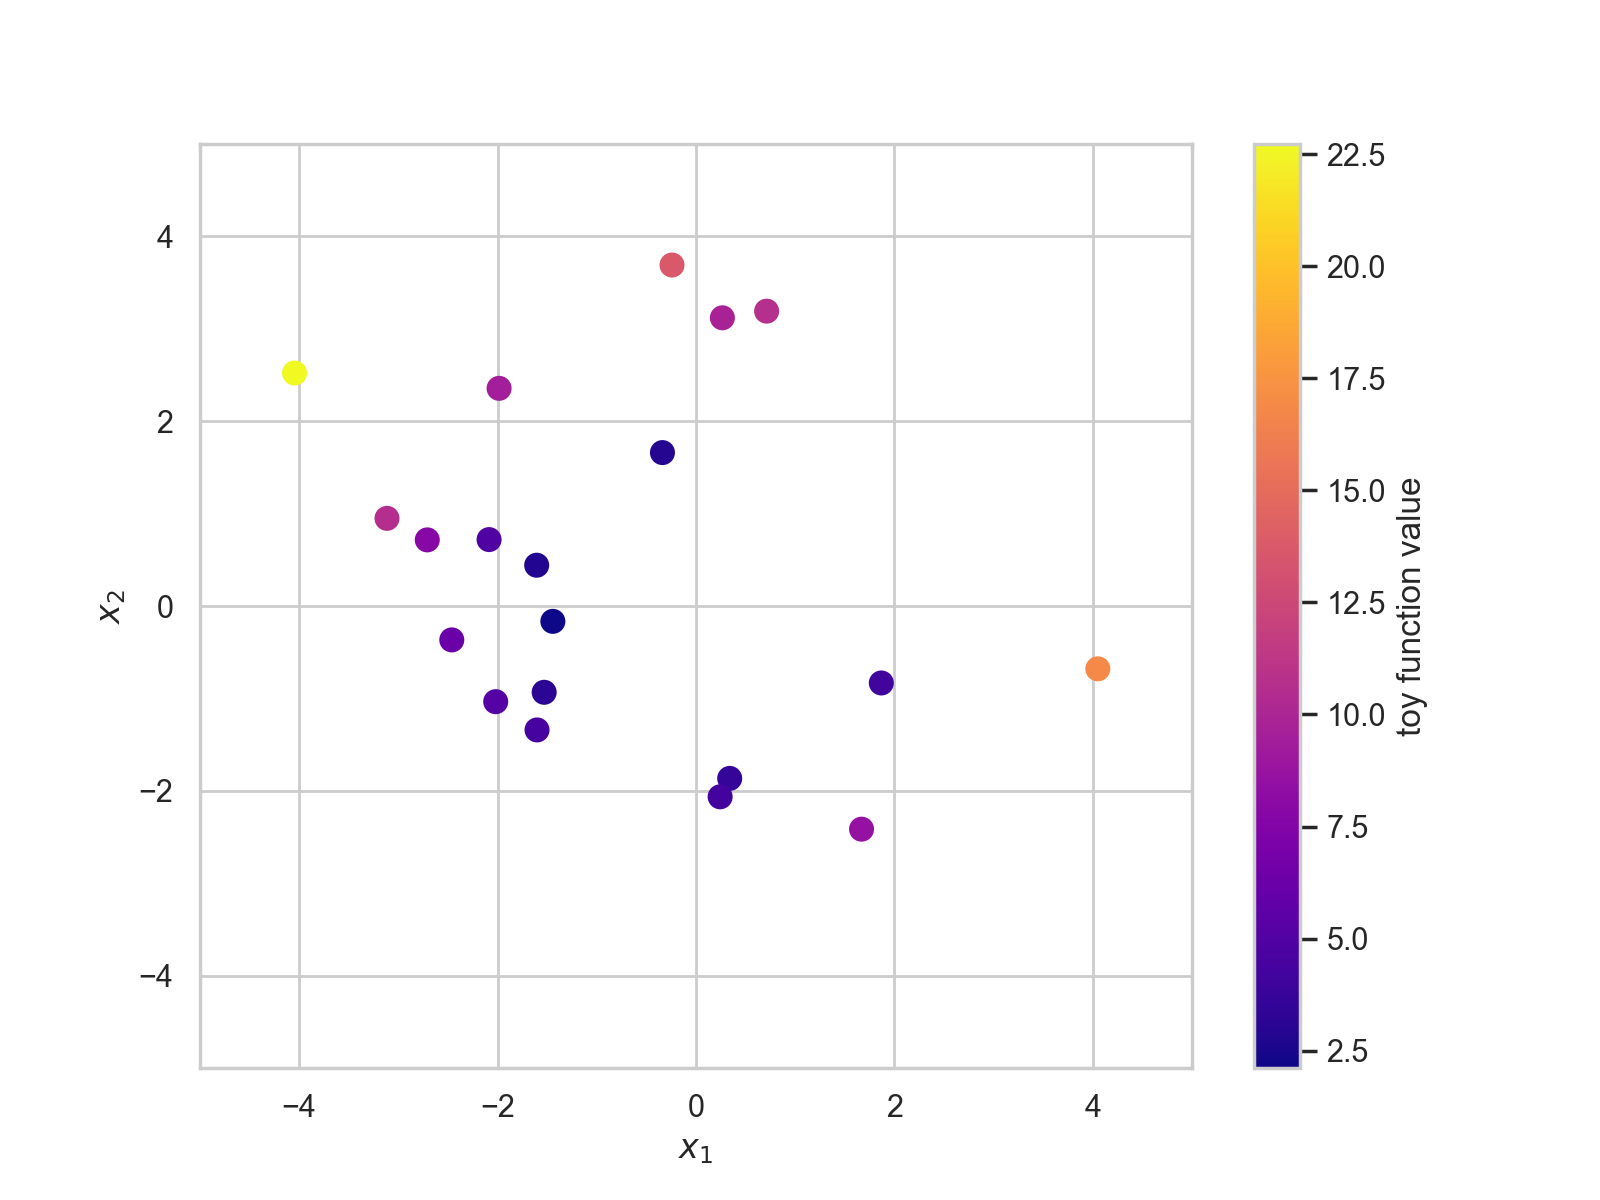

In [4]:
# Plot initial training set, colored by toy function values

plt.figure()
plt.scatter(np.array(toy_x)[:,0], np.array(toy_x)[:,1],
            c=toy_y, cmap=plt.cm.plasma)
plt.colorbar(label='toy function value');
plt.xlabel(r'$x_1$'); plt.ylabel(r'$x_2$');
plt.xlim(-5,5); plt.ylim(-5,5);

In [5]:
# Write a PIF JSON dataset file
write_dataset_from_func(toy_func, "toy_initial_dataset.json", toy_x)

If this is not your first time running this notebook, you can change the following variables to match what you've already created.

In [6]:
dataset_id = 175622
# view_id = 9028

In [7]:
# Make a dataset, upload to Citrination, return/print the ID
dataset_id = upload_data_and_get_id(
    client,
    "toy_initial_dataset",
    "toy_initial_dataset.json",
    create_new_version=True,
  given_dataset_id=dataset_id
)
print(f"Dataset created: {dataset_id}")

Dataset created: 175622


In [8]:
# Make a data view on Citrination, return/print the ID
import uuid
nonce = str(uuid.uuid4())
view_name = "toy_view_"+nonce
view_id = build_view_and_get_id(client, dataset_id, view_name, view_desc="toy test view",
                      input_keys=["Property x1", "Property x2"], output_keys=["Property y"])

print(f"Data view created: {view_id}")
print(f"Name is {view_name}")

Data view created: 9726
Name is toy_view_b10fdc23-8827-4d14-b6ee-44fb16f2f4df


# Running design

Now we call a function that runs the SL process. In short, we run a loop where we do the following:

1. Submit a design run (and poll status w/ wait times)
1. Get best candidates and record predicted results
1. Measure candidates (using toy function evaluation) and record measured results
1. Add candidates to dataset
1. Retrain on dataset (and poll status w/ wait times)
1. Repeat until max iterations reached

Detailed comments can be found in the [function docstring](sequential_learning_wrappers.py).

<IPython.core.display.Javascript object>


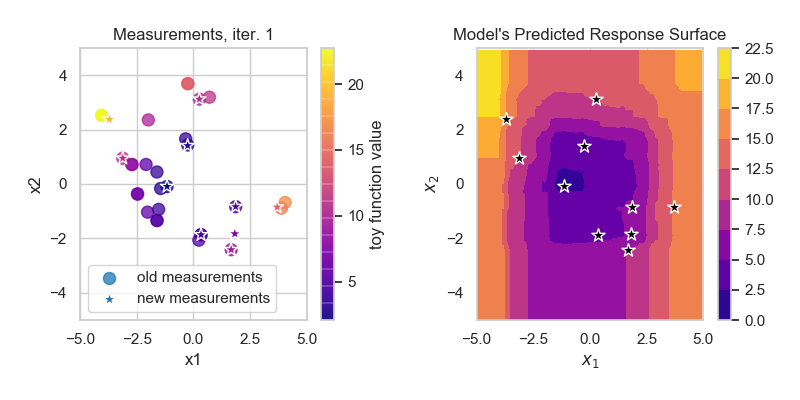

In [62]:
fig, (ax_data, ax_model) = plt.subplots(1,2,
                                        figsize=(8,4),
                                        gridspec_kw={'wspace':0.4,
                                                     'bottom':0.2,
                                                     'left':0.1,
                                                     'right':0.95})

In [63]:
best_sl_pred_vals, best_sl_measured_vals = run_sequential_learning(
    client=client,
    view_id=str(view_id),
    dataset_id=str(dataset_id),
    num_candidates_per_iter=10,
    design_effort=20,
    wait_time=5,
    num_sl_iterations=2,
    input_properties=["Property x1", "Property x2"],
    target=["Property y", "Min"],
    print_output=True,
    true_function=toy_func,
    score_type="MLI",
    ax_data=ax_data,
    ax_model=ax_model
)


---STARTING SL ITERATION #1---
Design ready
Created design run with ID a9eb6f1f-45e3-49ae-b9e1-6eade6a94484
Design run status: Accepted
Design run status: Processing
Design run status: Processing
Design run status: Finished
SL iter #1, best predicted (value, uncertainty) = ('1.3543246332658225', '0.0')
Dataset updated: 10 candidates added
New dataset contains 29 PIFs
Design ready

---STARTING SL ITERATION #2---
Design ready
Created design run with ID 3b0a48ee-d5b3-4128-8943-48f9d375482f
Design run status: Accepted
Design run status: Processing
Design run status: Processing
Design run status: Finished
SL iter #2, best predicted (value, uncertainty) = ('1.3543246332658225', '0.0')
Dataset updated: 10 candidates added
New dataset contains 38 PIFs
Design ready
Design ready
SL finished!



In [61]:
# Reset dataset after each SL run
dataset_id = upload_data_and_get_id(
    client,
    "toy_initial_dataset",
    "toy_initial_dataset.json",
    create_new_version=True,
    given_dataset_id=dataset_id
)
dataset_id

175622

## Examining the results

Finally, we can plot the results: Here, we are plotting the best measured candidate against the number of SL iterations in blue. In this case, lower = better for the measured results (since we are doing function minimization). The best predicted candidate is shown in yellow, with the uncertainty (error) at each iteration in green. As we can see, the uncertainty decreases as the number of SL iterations increase, and eventually our best candidates, both measured and predicted, perform better than the best value in the training set (black line).

In [ ]:
best_sl_pred_vals

In [ ]:
plt.figure()
plot_sl_results(best_sl_measured_vals, best_sl_pred_vals, initial_best_measured_value)

## Conclusion
To recap, this notebook went through the steps for running SL using the API.
1. First, we created and uploaded an initial dataset.
1. Then, we created a data view and trained the model.
1. We ran the SL process, measuring and updating new candidates after each iteration.
1. Finally we examined our SL results.

## Additional resources
It's now possible to conduct the major aspects of the Citrination workflow through the API, which should increase the speed and flexibility of informatics approaches. Some other topics that might interest you include:
* [DataClient](http://citrineinformatics.github.io/python-citrination-client/tutorial/data_examples.html) - This allows you to create datasets and upload PIF data (only) using the API.
  * There is also a corresponding [tutorial](1_data_client_api_tutorial.ipynb).

* [DataViewsClient](https://github.com/CitrineInformatics/python-citrination-client/tree/develop/citrination_client/views) - This allows you to build views (i.e. train ML models) using the API.
  * There is also a corresponding [tutorial](2_data_views_api_tutorial.ipynb).

# Nils' Appendix
I want to visualize the sequential learning run in the (x1,x2) design space as it generates and tests candidates. This means breaking down `run_sequential_learning` into steps and plotting results as they come out.

## How to build fake candidates

In [ ]:
dv_descriptors = client.data_views.get(view_id)['configuration']['descriptors'][::-1]
input_keys = [d['descriptor_key'] for d in dv_descriptors[:-1]]
input_keys

In [ ]:
lb=-5; ub=5; dx=0.1;
x1_range = np.arange(lb,ub,dx)
x2_range = np.arange(lb,ub,dx)
xx_grid = np.meshgrid(x1_range, x2_range)
xx_grid

In [ ]:
candidate_grid = [{input_keys[0]:x1_val,
                   input_keys[1]:x2_val}
                  for x1_val,x2_val in zip(xx_grid[0].ravel(),xx_grid[1].ravel())]
candidate_grid

In [ ]:
predictions_grid = client.models.predict(str(view_id), candidate_grid)
pred_vals_list = [pred._values['Property y']._value for pred in predictions_grid]
pred_vals_grid = np.array(pred_vals_list).reshape(xx_grid[0].shape)
pred_vals_grid.shape

In [ ]:
plt.figure()
cf = plt.contourf(xx_grid[0],
             xx_grid[1],
             pred_vals_grid,
             cmap=plt.cm.plasma)
plt.colorbar(label='modeled response surface value')
plt.xlabel(r'$x_1$'); plt.ylabel(r'$x_2$');
plt.xlim(-5,5); plt.ylim(-5,5);

In [56]:
# Get the current dataset into a pandas DataFrame

query_dataset = PifSystemReturningQuery(size=9999,
                            query=DataQuery(
                                dataset=DatasetQuery(
                                    id=Filter(equal=str(dataset_id))
                        )))
query_result = client.search.pif_search(query_dataset)
query_result

In [60]:
result_list = [{prop._name:prop._scalars[0]._value for prop in result._system._properties}
               for result in query_result._hits]
df_current = pd.DataFrame(result_list).astype(float)
df_current['updated_at'] = [hit._updated_at for hit in query_result._hits]
df_current.sort_values('updated_at')

,x1,x2,y,updated_at
3,0.339633,-1.865950,3.597119,2019-04-29T12:45:14.993Z
5,-1.606127,0.441356,2.774438,2019-04-29T12:45:15.225Z
2,-2.461872,-0.366966,6.195477,2019-04-29T12:45:15.57Z
31,-2.019224,-1.035521,5.149568,2019-04-29T12:45:15.743Z
36,1.668736,-2.415253,8.618128,2019-04-29T12:45:15.901Z
13,0.711951,3.191120,10.690120,2019-04-29T12:45:16.212Z
23,-1.602463,-1.341352,4.367115,2019-04-29T12:45:16.46Z
12,0.265949,3.119217,9.800241,2019-04-29T12:45:16.633Z
32,-1.985089,2.355625,9.489544,2019-04-29T12:45:16.882Z
10,-2.708901,0.715484,7.850063,2019-04-29T12:45:17.074Z


In [ ]:
design_id = client.submit_design_run(
                data_view_id=view_id,
                num_candidates=10,
                effort=20,
                target=Target(*["Property y", "Min"]),
                constraints=[],
                sampler="Default"
            ).uuid
print(design_id)

In [ ]:
import pandas as pd
candidates = client.get_design_run_results(view_id, design_id).next_experiments
df_cand = pd.DataFrame(candidates)
df_cand[list(df_cand['descriptor_values'].iloc[0].keys())] = \
    df_cand['descriptor_values'].apply(pd.Series)
df_cand = df_cand.drop(['descriptor_values', 'constraint_likelihoods'], axis=1)
df_cand = df_cand[df_cand.columns[[1,5,6,4,3,2,0]]].astype(float)
df_cand

In [ ]:
# Plot training points as circles, candidates as stars

fig, ax = plt.subplots()
ax.scatter('x1', 'x2', c = 'y',
            data = df_current,
            cmap = plt.cm.plasma,
            marker = 'o',
            s = 100,
            alpha = 0.5)
ax.scatter('Property x1', 'Property x2', c='Property y',
            data = df_cand,
            cmap = plt.cm.plasma,
            marker = '*',
            s = 200)
plt.colorbar(label='toy function value')
plt.xlabel(r'$x_1$')
plt.ylabel(r'$x_2$')
plt.xlim(-5,5)
plt.ylim(-5,5)

So we can build this plotting functionality into the `run_sequential_learning` script now, and with `%matplotlib notebook`, we can update the plot synchronously. Let's try again.